In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm import tqdm
import optax

import embedding_models
import maf_flow
import train

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Problem Setup

In [2]:
# Set up our dataset.
r_std, r_mean = 0.01, 0.1
def draw_two_moons(rng, theta):
    """Draw two moons following APT paper."""
    rng_a, rng_r = jax.random.split(rng)
    a = jax.random.uniform(rng_a, minval=-jnp.pi/2, maxval=jnp.pi/2)
    r = jax.random.normal(rng_r) * r_std + r_mean
    p = jnp.array([r * jnp.cos(a) + 0.25, r * jnp.sin(a)])
    return p + jnp.array(
        [
            -jnp.abs(jnp.sum(theta))/jnp.sqrt(2),
            (-theta[0] + theta[1])/jnp.sqrt(2)
        ]
    )

def draw_param(rng, x):
        rng_a, rng_r, rng_q = jax.random.split(rng, 3)
        a = jax.random.uniform(rng_a, minval=-jnp.pi/2, maxval=jnp.pi/2)
        r = jax.random.normal(rng_r) * r_std + r_mean
        p = jnp.array([r * jnp.cos(a) + 0.25, r * jnp.sin(a)])
        
        q_zero = p[0] - x[0]
        q_one = x[1] - p[1]

        flip = jax.random.normal(rng_q) < 0.0
        q_zero = flip * q_zero - (~flip) * q_zero
        q_one = flip * q_one - (~flip) * q_one

        return jnp.array(
            [
                q_zero/jnp.sqrt(2) - q_one/jnp.sqrt(2),
                q_zero/jnp.sqrt(2) + q_one/jnp.sqrt(2)
            ]
        )

def draw_joint_two_moons(rng):
    """Return theta and x from two moons simulation."""
    rng_theta, rng_x = jax.random.split(rng)
    theta = jax.random.uniform(rng, shape = (2,), minval=-2.0, maxval=2.0)
    return (theta, draw_two_moons(rng_x, theta))


draw_batch = jax.jit(jax.vmap(draw_joint_two_moons))
draw_obs = jax.jit(jax.vmap(draw_two_moons, in_axes=[0, None]))
draw_obs_conds = jax.jit(jax.vmap(draw_two_moons))
draw_thetas = jax.jit(jax.vmap(draw_param, in_axes=[0, None]))
draw_thetas_cond = jax.jit(jax.vmap(draw_param))

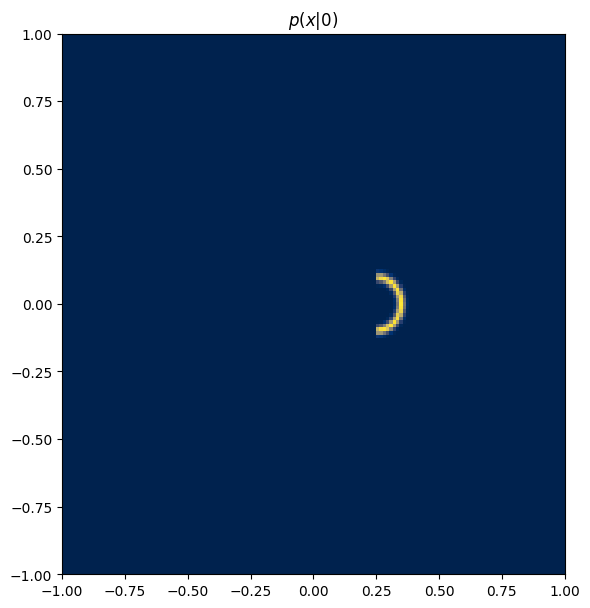

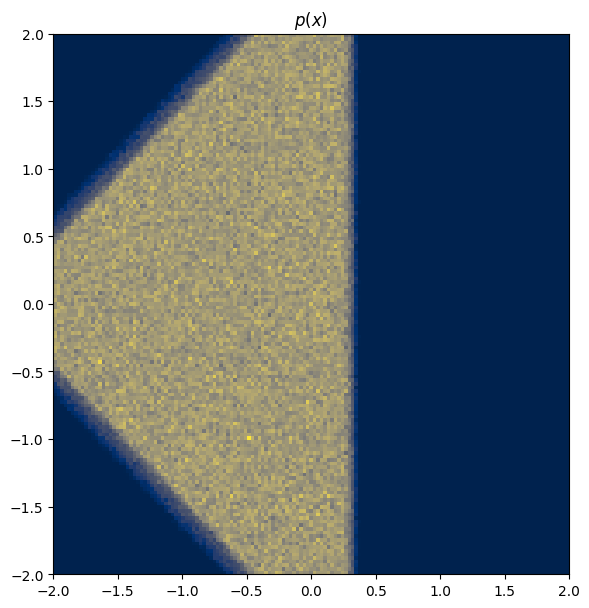

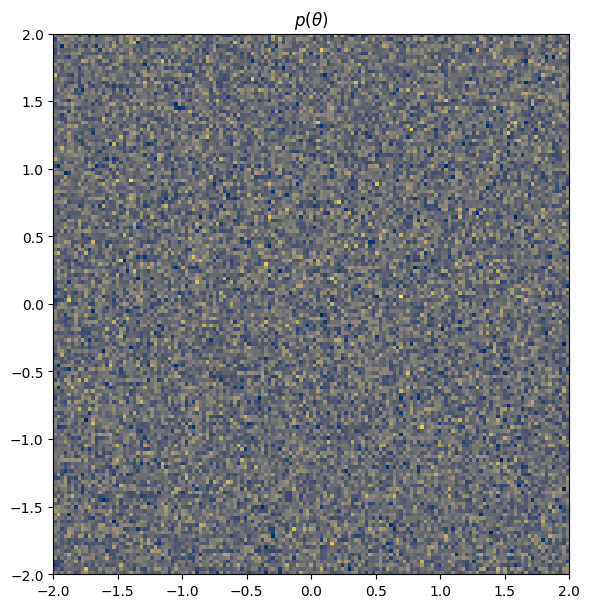

In [3]:
# Plot some distributions to get a sense of the two moons problem
batch_size = 1_000_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
x_samples = draw_obs(rng_batch, jnp.array([0.0, 0.0]))

fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(x|0)$')
plt.show()

theta_samples, x_samples = draw_batch(rng_batch)
fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1], 
    bins=[jnp.linspace(-2, 2, n_bins), jnp.linspace(-2, 2, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(x)$')
plt.show()
theta_samples, x_samples = draw_batch(rng_batch)
fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.hist2d(
    theta_samples[:, 0], theta_samples[:, 1], 
    bins=[jnp.linspace(-2, 2, n_bins), jnp.linspace(-2, 2, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(\theta)$')
plt.show()

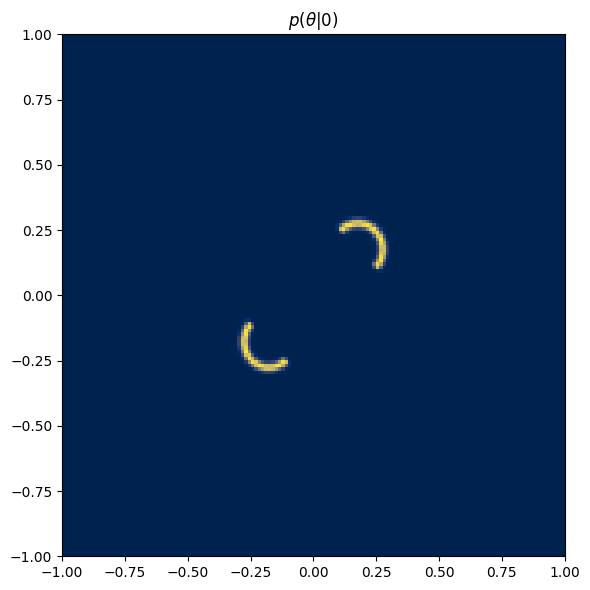

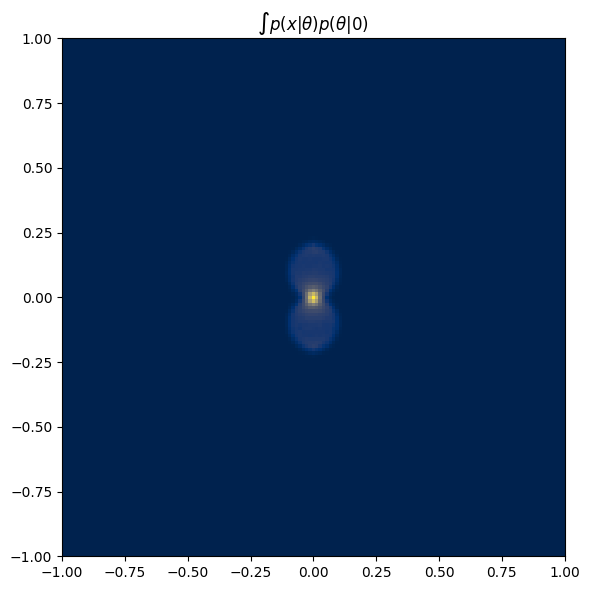

In [4]:
# Plot our target distribution for our context of 0.
batch_size = 1_000_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
theta_true = draw_thetas(rng_batch, jnp.array([0.0, 0.0]))
x_samples = draw_obs_conds(rng_batch, theta_true)

fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.title(r'$p(\theta|0)$')
plt.hist2d(
    theta_true[:, 0], theta_true[:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.title(r'$\int p(x|\theta)p(\theta|0)$')
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()

## Model Setup

In [45]:
parameter_dim = 2
n_maf_layers = 5
hidden_dims_maf = [32]
hidden_layers_mlp = []
activation_mlp ='gelu'
activation_maf = 'tanh'
context_dim = 2

embedding_module = embedding_models.MLP(context_dim, hidden_layers_mlp, activation_mlp)
maf_model = maf_flow.MAF(parameter_dim, n_maf_layers, hidden_dims_maf, activation_maf)
model = maf_flow.EmbeddedFlow(embedding_module, maf_model)

# Initialize the train state.
rng = jax.random.PRNGKey(1)
optimizer = 'adam'
learning_rate = 1e-3
steps_per_epoch = 1_000
learning_rate_schedule = optax.exponential_decay(learning_rate, steps_per_epoch, 0.9)
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)
sample_func = jax.jit(
    functools.partial(state.apply_fn, method='sample', mutable=('batch_stats',)),
    static_argnames=['sample_shape',]
)
# If you change the underlying model, you must create a new train_step function since it depends on the
# optimizer mask which depends on the maf_model structure.
train_step = jax.jit(train.train_step, static_argnames=['learning_rate_schedule', 'n_atoms'])

In [36]:
batch_size = 512
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

rng, _ = jax.random.split(rng)
rng_batch = jax.random.split(rng, batch_size)
theta_batch, x_batch = draw_batch(rng_batch)
batch = {'truth': theta_batch, 'context': x_batch}
n_atoms = 128

new_state, metrics = train_step(rng, state, batch, mu_prior, prec_prior, learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms)

In [66]:
n_steps = 1_000
max_width = len(str(n_steps))
n_warmup = 900
sample_shape = (4096,)
steps_per_epoch = 100
theta_batch_samps = []
x_batch_samps = []

x_obs = jnp.zeros((1, 2))

for step in range(n_steps):

    # Sample a batch
    train_metrics_last_t = time.time()
    rng, _ = jax.random.split(rng)
    rng_batch = jax.random.split(rng, batch_size)

    theta_batch, x_batch = draw_batch(rng_batch)
    batch = {'truth': theta_batch, 'context': x_batch}
    
    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior, 
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        print(f'step {step:>{max_width}}:', metrics)
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            rng, x_obs, 
            sample_shape=sample_shape
        )
        theta_batch_samps.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))

step    0: {'learning_rate': Array(0.00076973, dtype=float32, weak_type=True), 'loss': Array(1.2637404, dtype=float32)}
step  100: {'learning_rate': Array(0.00076166, dtype=float32, weak_type=True), 'loss': Array(1.1219218, dtype=float32)}
step  200: {'learning_rate': Array(0.00075368, dtype=float32, weak_type=True), 'loss': Array(1.1562316, dtype=float32)}
step  300: {'learning_rate': Array(0.00074578, dtype=float32, weak_type=True), 'loss': Array(1.0548402, dtype=float32)}
step  400: {'learning_rate': Array(0.00073796, dtype=float32, weak_type=True), 'loss': Array(1.1797497, dtype=float32)}
step  500: {'learning_rate': Array(0.00073023, dtype=float32, weak_type=True), 'loss': Array(1.2497636, dtype=float32)}
step  600: {'learning_rate': Array(0.00072258, dtype=float32, weak_type=True), 'loss': Array(1.1200677, dtype=float32)}
step  700: {'learning_rate': Array(0.000715, dtype=float32, weak_type=True), 'loss': Array(1.0776259, dtype=float32)}
step  800: {'learning_rate': Array(0.00070

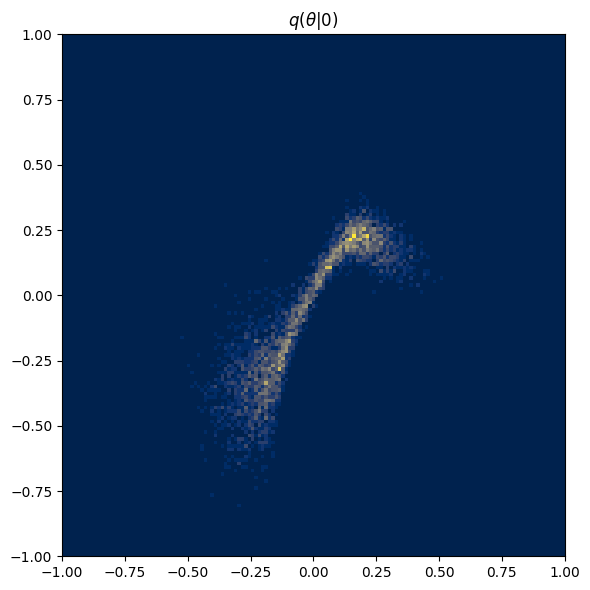

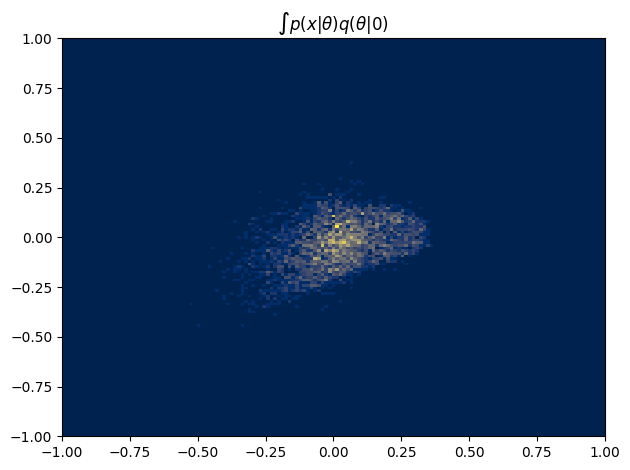

In [76]:
i = 9
fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.title(r'$q(\theta|0)$')
plt.hist2d(
    theta_batch_samps[i][:, 0], theta_batch_samps[i][:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()
plt.title(r'$\int p(x|\theta)q(\theta|0)$')
plt.hist2d(
    x_batch_samps[i][:, 0], x_batch_samps[i][:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()